<a href="https://colab.research.google.com/github/akhmadMizkat/gan-floor-plan-generator/blob/main/Floor_Planner_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import statements

In [ ]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch import optim as optim
import pandas as pd
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
torch.multiprocessing.set_start_method('spawn')

# Select Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Initiate Data Loader

In [ ]:
from torch.utils.data import DataLoader, Dataset
import cv2
import glob
from pandas.core.common import flatten
import random

In [ ]:
import PIL
from PIL import Image


In [ ]:
train_data_path = '/content/drive/MyDrive/floor-planer-cgan/images/train/CLEAN_PIC_64' 

train_image_paths = [] #to store image paths in list
train_metadata = [] #to store metadata used in conditional gan

raw_metadata = pd.read_csv(train_data_path + '/' + 'metadata.csv')
for data_path in glob.glob(train_data_path + '/*.png'):
  id = int(data_path.split('/')[-1].split(".")[0])
  
  train_metadata.append(raw_metadata[raw_metadata["Unnamed: 0"] == 592].to_numpy()[0][1:]) # [1:] agar index tidak dimasukan pada metadata
  train_image_paths.append(data_path)

print('train_image_path example: ', train_image_paths[0])
print('metadata example: ', train_metadata[0])

train_image_path example:  /content/drive/MyDrive/floor-planer-cgan/images/train/CLEAN_PIC_64/28124.png
metadata example:  [ 2  1  7  3  0 -1 -1 -1]


In [ ]:
class FloorPlanDataset(Dataset):
    def __init__(self, image_paths, metadata, transform=None):
        self.image_paths = image_paths
        self.metadata = metadata
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        metadata = self.metadata[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, metadata

# Load dataset and declare training parameters

In [ ]:
from torch.utils.data.dataloader import default_collate

training_parameters = {
    "n_epochs": 100,
    "batch_size": 100,
}

# bulatkan, jangan ada batch dibawah batch size
train_image_paths = train_image_paths[:-(len(train_image_paths) % training_parameters["batch_size"])]
train_metadata = train_metadata[:-(len(train_metadata) % training_parameters["batch_size"])]

train_dataset = FloorPlanDataset(train_image_paths, train_metadata, transform=None)

data_loader = DataLoader(
    train_dataset, batch_size=training_parameters["batch_size"], shuffle=False,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
)

In [ ]:
num_batches = len(data_loader)
print("Number of batches: ",num_batches)

Number of batches:  25


# Display an image

In [ ]:
#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_floors(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    # dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx)
    plt.tight_layout(pad=1)
    plt.show()

In [ ]:
cv2.imread("/content/drive/MyDrive/floor-planer-cgan/images/train/CLEAN_PIC_64/10027.png").shape

(64, 64, 3)

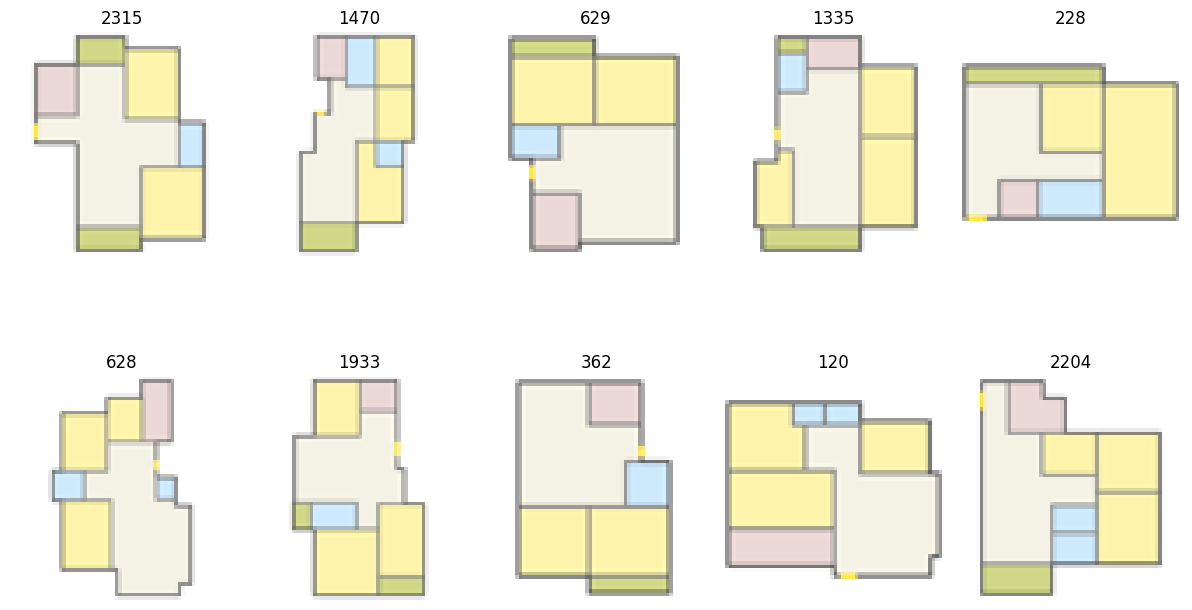

In [ ]:
visualize_floors(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


# Define Generator and Discriminator

In [ ]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        input_dim = 256 + 8
        output_dim = 64 * 64 * 3

        self.meta_embedding = nn.Embedding(8, 10)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(2048, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, metadata):
        # m = self.meta_embedding(metadata)
        x = torch.cat([x, metadata.to(torch.float)], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)

class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        input_dim = 3 * (64*64) + 8
        output_dim = 1

        self.meta_embedding = nn.Embedding(8, 10)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, metadata):
        # m = self.meta_embedding(metadata)
        x = torch.cat([x, metadata.to(torch.float)], 1)

        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output.to(device)

discriminator = DiscriminatorModel()
generator = GeneratorModel()
discriminator.to(device)
generator.to(device)

GeneratorModel(
  (meta_embedding): Embedding(8, 10)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=264, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=2048, out_features=12288, bias=True)
    (1): Tanh()
  )
)

# Initilize Optimizers, loss function


In [ ]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()


# Training Loop

In [ ]:
n_epochs = training_parameters["n_epochs"]
batch_size = training_parameters["batch_size"]

for epoch_idx in range(n_epochs):
    G_loss = []
    D_loss = []
    for batch_idx, data_input in enumerate(data_loader):
        noise = torch.randn(batch_size,256).to(device)
        fake_metadata = torch.from_numpy(raw_metadata.sample(batch_size).to_numpy()[:,1:]).to(device)
        generated_data = generator(noise, fake_metadata) # batch_size x 64 X 64
        
        # Discriminator
        # print(data_input[1])
        true_data = data_input[0].view(batch_size, 3*64*64).to(device) # batch_size X 64 X 64
        metadata = data_input[1] # batch_size
        true_labels = torch.ones(batch_size).to(device)
        
        discriminator_optimizer.zero_grad()

        discriminator_output_for_true_data = discriminator(true_data, metadata).view(batch_size)
        true_discriminator_loss = loss(discriminator_output_for_true_data, true_labels)

        discriminator_output_for_generated_data = discriminator(generated_data.detach(), fake_metadata).view(batch_size)
        generator_discriminator_loss = loss(
            discriminator_output_for_generated_data, torch.zeros(batch_size).to(device)
        )
        discriminator_loss = (
            true_discriminator_loss + generator_discriminator_loss
        ) / 2
        
        discriminator_loss.backward()
        discriminator_optimizer.step()

        D_loss.append(discriminator_loss.data.item())
        
        
        # Generator
        generator_optimizer.zero_grad()
        # It's a choice to generate the data again
        generated_data = generator(noise, fake_metadata) # batch_size X 784
        discriminator_output_on_generated_data = discriminator(generated_data, fake_metadata).view(batch_size)
        generator_loss = loss(discriminator_output_on_generated_data, true_labels)
        generator_loss.backward()
        generator_optimizer.step()
        
        G_loss.append(generator_loss.data.item())
        if ((batch_idx + 1)% 500 == 0 and (epoch_idx + 1)%10 == 0):
            print("Training Steps Completed: ", batch_idx)
            
            with torch.no_grad():
                noise = torch.randn(batch_size,100).to(device)
                generated_data = generator(noise).cpu().view(batch_size, 28, 28)
                for x in generated_data:
                    plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
                    plt.show()

                    break


    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
    

[0/100]: loss_d: 32.558, loss_g: 2.507
[1/100]: loss_d: 50.200, loss_g: 1.799
[2/100]: loss_d: 50.057, loss_g: 2.836
[3/100]: loss_d: 50.018, loss_g: 4.883
[4/100]: loss_d: 50.012, loss_g: 7.414
[5/100]: loss_d: 50.001, loss_g: 8.974
[6/100]: loss_d: 50.000, loss_g: 9.257
[7/100]: loss_d: 50.000, loss_g: 9.134
[8/100]: loss_d: 50.001, loss_g: 9.638
[9/100]: loss_d: 50.000, loss_g: 10.626
[10/100]: loss_d: 50.000, loss_g: 10.419
[11/100]: loss_d: 50.000, loss_g: 10.715
[12/100]: loss_d: 50.000, loss_g: 10.820
[13/100]: loss_d: 50.000, loss_g: 11.081
[14/100]: loss_d: 50.000, loss_g: 11.345
[15/100]: loss_d: 50.000, loss_g: 11.451
[16/100]: loss_d: 50.000, loss_g: 11.597
[17/100]: loss_d: 50.000, loss_g: 11.989
[18/100]: loss_d: 50.000, loss_g: 12.670
[19/100]: loss_d: 50.000, loss_g: 13.104
[20/100]: loss_d: 50.000, loss_g: 13.241
[21/100]: loss_d: 50.000, loss_g: 13.552
[22/100]: loss_d: 50.000, loss_g: 13.809
[23/100]: loss_d: 50.000, loss_g: 13.819
[24/100]: loss_d: 50.000, loss_g: 1

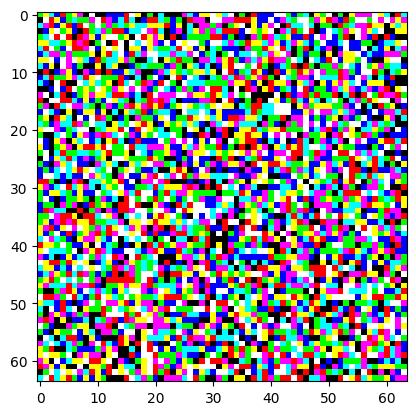

In [ ]:
with torch.no_grad():
  noise = torch.randn(batch_size,256).to(device)
  generated_data = generator(noise, torch.from_numpy(raw_metadata.sample(batch_size).to_numpy()[:,1:]).to(device)).cpu().view(batch_size, 64, 64, 3)
  for x in generated_data:
      plt.imshow(x.detach().numpy(), interpolation='nearest')
      plt.show()
      break